In [1]:
from sklearn.decomposition import TruncatedSVD
from skimage import data

import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg

import itertools
from typing import List

SEED = 10

Plot of the original image in black and white.

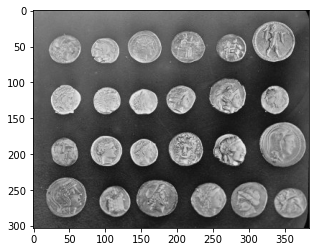

In [2]:
image = data.coins()
plt.imshow(image, cmap=plt.cm.gray)

In [3]:
print(image.shape)

(303, 384)


Given a real matrix $A \in {\rm I\!R}^{n\text{x}m}$ with rank $r$, its singular value decomposition is: 
$$
A = U \Sigma V = \sum_{i=1}^{r} \sigma_i u_i v_i^T
$$
The Frobenius **squared** norm of A is:
$$
{\lVert A \rVert}_F^2 = \sum_{i=1}^{r} \sigma_i^2
$$
Now, let $A_k = \sum_{i=1}^{k} \sigma_i u_i v_i^T$ be the rank-k approximation of $A$ for $k < r$. It also holds that the Frobenius **squared** norm of $A_k$ is the sum of its squared singular values:
$$
{\lVert A_k \rVert}_F^2 = \sum_{i=1}^{k} \sigma_i^2
$$


In `sklearn` it is possible to get the singular values of an SVD decomposition by accessing the attribute `singular_values_`. Therefore, I can compute the Frobenius norm of the low-rank approximations by summing up the squared singular values and then taking the squared root:
    
    (sum(svd.singular_values_**2))**0.5

In [13]:
class Image_SVD_Approximation:
    def __init__(self, image: np.ndarray):
        self.image = image
        self.rank = linalg.matrix_rank(image)

        # Compute Frobenius Norm
        self.f_norm_original = linalg.norm(image, ord="fro")


    @staticmethod
    def compute_truncated_SVD(matrix: np.ndarray, k: int) -> np.ndarray:
        svd = TruncatedSVD(n_components=k, n_iter=7, random_state=SEED)
        svd_matrix = svd.fit_transform(matrix)
        return svd, svd.inverse_transform(svd_matrix)


    def plot_image_low_rank_approximation(self, percentage_of_singular_values: float):
        fig, axs = plt.subplots(1, 2, figsize=(16,9))

        # Plot original image
        axs[0].imshow(image, cmap=plt.cm.gray)
        axs[0].set_title("Original Image")

        
        k = int(self.rank * percentage_of_singular_values/100)
        svd, image_k_rank = self.compute_truncated_SVD(self.image, k)

        f_norm_approximation = (sum(svd.singular_values_**2))**0.5
        f_norm_percentage = f_norm_approximation / self.f_norm_original

        # Plot low rank approximation
        axs[1].imshow(image_k_rank, cmap=plt.cm.gray)
        axs[1].set_title(f"{k} Singular Values ({percentage_of_singular_values}%)\nPercentage of F-norm: {f_norm_percentage*100:.3f}%")

        plt.show()

    def plot_grid_low_rank_approximation(self, percentages_of_singular_values: List[float]):
        # Plot original image
        plt.imshow(image, cmap=plt.cm.gray)
        plt.title("Original Image", fontsize=14)

        # Plot low rank approximations        
        fig, axs = plt.subplots(2, 2, figsize=(16,11))
        fig.suptitle('Low Rank Approximations', fontsize=16)

        # Plot 2x2 subplots with the four percentages
        for (p_idx, (i, j)) in enumerate(itertools.product(range(2), range(2))):
            p = percentages_of_singular_values[p_idx]
            k = int(self.rank * p/100)
            svd, image_k_rank = self.compute_truncated_SVD(self.image, k)

            f_norm_approximation = (sum(svd.singular_values_**2))**0.5
            f_norm_percentage = f_norm_approximation / self.f_norm_original

            axs[i, j].imshow(image_k_rank, cmap=plt.cm.gray)
            axs[i, j].set_title(f"{k} Singular Values ({p}%)\nPercentage of F-norm: {f_norm_percentage*100:.3f}%")

        plt.show()


    def plot_singular_values_energy(self, k: int):
        # If k is greater than the rank, set it to be equal to the rank
        k = min(k, self.rank)

        svd = TruncatedSVD(n_components=self.rank, n_iter=7, random_state=SEED)
        svd.fit(self.image)
        plt.plot(np.arange(1, k+1), svd.singular_values_[:k]**2, marker="o")

        plt.ylabel('Energy', fontsize=12)
        plt.xlabel('Singular Values', fontsize=12)
        plt.show()


In [14]:
percentages_of_singular_values = [5, 10, 25, 50]

image_svd = Image_SVD_Approximation(image)

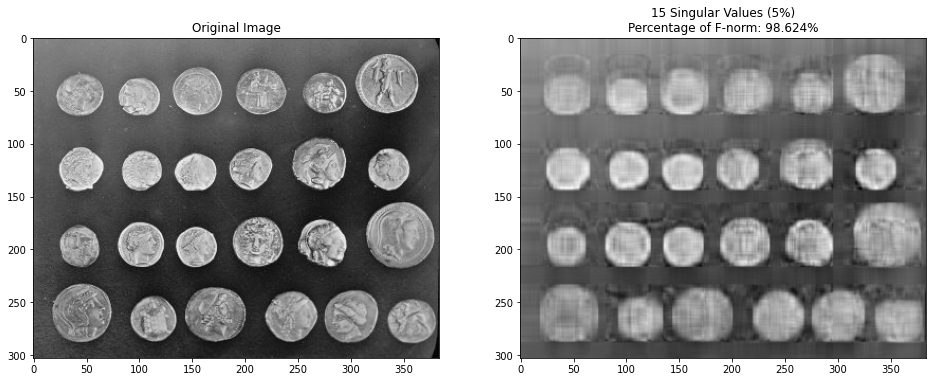

In [15]:
image_svd.plot_image_low_rank_approximation(5)

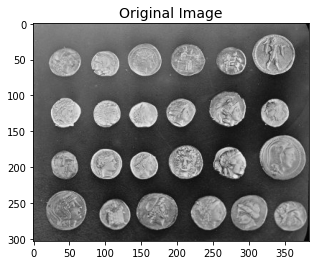

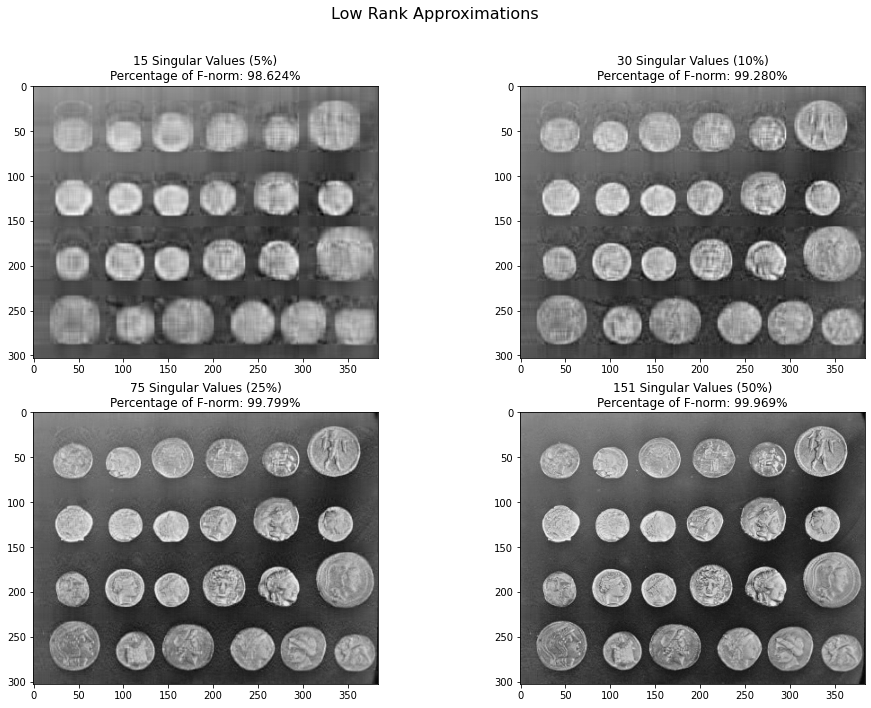

In [16]:
image_svd.plot_grid_low_rank_approximation(percentages_of_singular_values)

As we can see, the approximation are quite good, especially the third one even if it uses only 25% of the singular values. 

Moreover, we retain most of the energy (Frobenius norm) of the original image already with the 5% approximation. This implies that the majority of the energy is contained in the first singular values. 

I want to investigate more the singular values to see how much energy they retain. The following is a graph representing the first $k$ singular values along with their energy: 
$$ 
{\lVert A v_i \rVert}_2^2 = \sigma_i^2 \ \ \forall i
$$

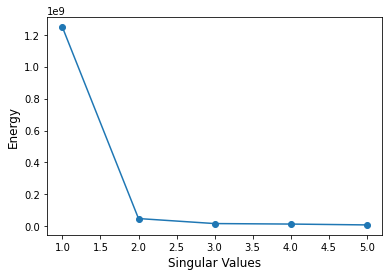

In [17]:
image_svd.plot_singular_values_energy(5)

The first singular value retain the majority of the energy, thus we can also use one single singular value to decompose the original image, still preserving a good percentage of its norm.

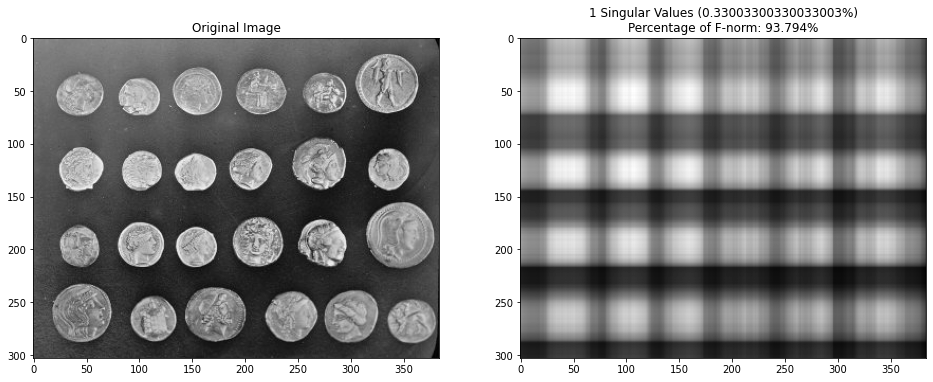

In [18]:
image_svd.plot_image_low_rank_approximation((100/image_svd.rank))

In this case it is true that the first singular value preserve most of the energy, but the image becomes almost incomprehensible.